In [4]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval
import librosa
import math
from datetime import datetime

import audio_functions as af
import model_functions as mf
import audio_models
import dataset
import importlib

In [59]:
importlib.reload(audio_models)

<module 'audio_models' from '/home/enterprise.internal.city.ac.uk/acvn728/MScFinalProject/audio_models.py'>

In [77]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=False
batch_size = 5
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002

    
#checkpoint = '52/52-10' #  Best U-net
checkpoint = '134/134-3'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

#directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Mixed'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Voice'
directory_c = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Background'

#directory_a = '/data/Speech_Data/LibriSpeech/Mixed/test-clean/1580/141083/'
#directory_b = '/data/Speech_Data/LibriSpeech/Voice/test-clean/1580/141083/'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b, directory_c)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)
data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>

In [78]:
#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, _, mixed_audio, voice_audio, background_audio = pipe.get_next()
#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_real = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
mixed_imag = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 2], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 3], 3)

voice_real = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
voice_imag = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 2], 3)
voice_phase = tf.expand_dims(voice_spec[:, :, :-1, 3], 3)

In [44]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, 
                                    voice_audio, 'unet', is_training, learning_rate, 'mag', name='Magnitude_Model')

Creating model


TypeError: __init__() missing 1 required positional argument: 'data_type'

In [56]:
# Build U-Net with magnitude and pahse as input and output
mixed_inp = mixed_spec[:, :, :-1, 2:4]
voice_inp = voice_spec[:, :, :-1, 2:4]
print('Creating model')
model = audio_models.MagnitudeModel(mixed_inp, voice_inp, mixed_phase, mixed_audio, voice_audio, 
                                    background_audio, 'unet', is_training, learning_rate, 'mag_phase_diff', name='Magnitude_Model')

Creating model


In [ ]:
# Build U-Net with real and imaginary as input and output
mixed_inp = mixed_spec[:, :, :-1, 0:2]
voice_inp = voice_spec[:, :, :-1, 0:2]
print('Creating model')
model = audio_models.MagnitudeModel(mixed_inp, voice_inp, mixed_phase, mixed_audio, 
                                    voice_audio, 'unet', is_training, learning_rate, 'real_imag', name='Magnitude_Model')

In [79]:
# Build U-Net with magnitude, real and imaginary as input and output
mixed_inp = tf.concat([tf.expand_dims(mixed_spec[:, :, :-1, 2], axis=3), mixed_spec[:, :, :-1, 0:2]], axis=3)
voice_inp = tf.concat([tf.expand_dims(voice_spec[:, :, :-1, 2], axis=3), voice_spec[:, :, :-1, 0:2]], axis=3)
print('Creating model')
model = audio_models.MagnitudeModel(mixed_inp, voice_inp, mixed_phase, mixed_audio, voice_audio, background_audio,
                                    'unet', is_training, learning_rate, 'mag_real_imag', name='Magnitude_Model')

Creating model


In [80]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(pipe.initializer)

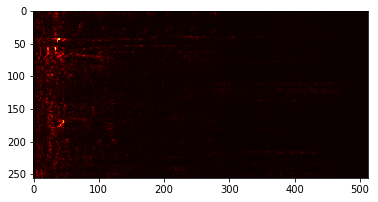

In [43]:
# Test the pipeline still works
m = sess.run(mixed_spec)

plt.imshow(m[0, :, :, 2])

complex_spec = np.empty((m.shape[1], m.shape[2]), dtype=complex)
complex_spec.real = m[0, :, :, 0]
complex_spec.imag = m[0, :, :, 1]

m_wave = librosa.istft(complex_spec.T, fft_hop)
ipd.Audio(m_wave.T, rate=sample_rate)

In [43]:
mix_mag, mix_phase, voice_mag, voice_est_mag, \
    mask, voice_wave, mix_wave, cost = sess.run([model.mixed_mag, 
                                                 model.mixed_phase, 
                                                 model.voice_mag,
                                                 model.gen_voice, 
                                                 model.voice_mask, 
                                                 model.voice_audio, 
                                                 model.mixed_audio,
                                                 model.cost],
                                                {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

In [69]:
# For magnitude and phase
for i in range(voice_mag.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est_mag[i, :, :, 0]).T, n_fft,
                                     fft_hop, phaseIterations=0, phase=np.squeeze(voice_est_mag[i, :, :, 1]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)
    

In [44]:
# For real and imaginary

complex_spec = np.empty((voice_est_mag.shape[0], voice_est_mag.shape[1], voice_est_mag.shape[2]), dtype=complex)
complex_spec.real = voice_est_mag[:, :, :, 0]
complex_spec.imag = voice_est_mag[:, :, :, 1]

for i in range(complex_spec.shape[0]):
    wave = librosa.istft(complex_spec[i].T, fft_hop)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)

In [70]:
voice_est_mag.shape

(5, 256, 512, 2)

In [60]:
mix_mag.shape

(5, 256, 512, 2)

In [58]:
ipd.Audio(voice_est_wave[0].T, rate=sample_rate)

In [91]:
def l1(x, y):
    return np.mean(np.abs(x - y))

print(l1(voice_est_mag[0,:,:,0], voice_mag[0,:,:,0]))
print(cost)

4.508612e-05
0.85150206


In [93]:
def phase_loss(x, y):
    
    original_dif = np.abs(x - y)
    add_2_pi_dif = np.abs(x - (y + 2 * math.pi))
    minus_2_pi_dif = np.abs(x - (y - 2 * math.pi))

    corrected_dif = np.minimum(original_dif, np.minimum(add_2_pi_dif, minus_2_pi_dif))

    return np.mean(corrected_dif)

print(phase_loss(voice_est_mag[0,:,:,1], voice_mag[0,:,:,1]))

1.566881


In [98]:
voice_mag[0,:,:,1].min()

-3.1415927

In [97]:
2 * math.pi

6.283185307179586

In [100]:
voice_mag[0,:,:,0].max()

0.0057107

In [45]:
mag_range = voice_mag[0,:,:,0].max() - voice_mag[0,:,:,0].min()
phase_range = voice_mag[0,:,:,1].max() - voice_mag[0,:,:,1].min()
print(mag_range, '\n', phase_range)

0.0110183 
 0.009891857


In [81]:
sess.run(pipe.initializer)
print('start: {}'.format(datetime.now()))
epochs = 2000
epoch = 0
epoch_cost = []
epoch_m_loss = []
epoch_r_loss = []
epoch_i_loss = []
i = 0
while epoch < epochs:
    try:
        #_, cost = sess.run([model.train_op, model.cost], {model.is_training:True})
        _, cost, m_loss, r_loss, i_loss = sess.run([model.train_op, model.cost, model.mag_loss, model.real_loss, model.imag_loss], {model.is_training:True})
        #print('Iteration {i}: {dt}\nCost: {c}'.format(i=i, dt=datetime.datetime.now(), c=cost))
        epoch_cost.append(cost)
        epoch_m_loss.append(m_loss)
        epoch_r_loss.append(r_loss)
        epoch_i_loss.append(i_loss)
        i += 1
    except tf.errors.OutOfRangeError:
        epoch_mean_cost = sum(epoch_cost)/len(epoch_cost)
        epoch_mean_m_loss = sum(epoch_m_loss)/len(epoch_m_loss)
        epoch_mean_r_loss = sum(epoch_r_loss)/len(epoch_r_loss)
        epoch_mean_i_loss = sum(epoch_i_loss)/len(epoch_i_loss)
        print('Epoch {e} finished. Mean cost = {emc}'.format(e=epoch, emc=epoch_mean_cost))
        print('\tMean magnitude loss = {emml}\n\tMean real loss = {emrl}'
              '\n\tMean Imaginary loss: {emil}'.format(emml=epoch_mean_m_loss, emrl=epoch_mean_p_loss, emil=epoch_mean_i_loss))
        epoch += 1
        sess.run(pipe.initializer)
print('finish: {}'.format(datetime.now()))

start: 2018-11-05 18:23:07.456238
Epoch 0 finished. Mean cost = 0.3178999722003937
	Mean magnitude loss = 0.40065231919288635
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.25022900104522705
Epoch 1 finished. Mean cost = 0.31482653319835663
	Mean magnitude loss = 0.39630985260009766
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.24829962849617004
Epoch 2 finished. Mean cost = 0.31182191769282025
	Mean magnitude loss = 0.3921857376893361
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.24629019697507223
Epoch 3 finished. Mean cost = 0.3090124949812889
	Mean magnitude loss = 0.3884339779615402
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.2443665936589241
Epoch 4 finished. Mean cost = 0.30628461241722105
	Mean magnitude loss = 0.38471052050590515
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.24260554909706117
Epoch 5 finished. Mean cost = 0.30355749527613324
	Mean magnitude loss = 0.3809131185213725
	Mean real los

Epoch 48 finished. Mean cost = 0.21181492294584
	Mean magnitude loss = 0.2529918937658777
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.17960563241219035
Epoch 49 finished. Mean cost = 0.21050822228193283
	Mean magnitude loss = 0.2511492949724197
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.17873473584651947
Epoch 50 finished. Mean cost = 0.20921673552662717
	Mean magnitude loss = 0.24933354059855142
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.17787268436422535
Epoch 51 finished. Mean cost = 0.20794698452720276
	Mean magnitude loss = 0.2475435366997352
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.17702534766151354
Epoch 52 finished. Mean cost = 0.20670627507398714
	Mean magnitude loss = 0.2457980716003562
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.17619880555935627
Epoch 53 finished. Mean cost = 0.20548388058388675
	Mean magnitude loss = 0.24407958846401284
	Mean real loss = 0.16010468229164485
	Mean

Epoch 97 finished. Mean cost = 0.16823508993399386
	Mean magnitude loss = 0.19342761205471293
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.14905881417953237
Epoch 98 finished. Mean cost = 0.16764075662752595
	Mean magnitude loss = 0.192643090706281
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.14861427601238694
Epoch 99 finished. Mean cost = 0.16705556012690068
	Mean magnitude loss = 0.19187325045466422
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.14817481957376002
Epoch 100 finished. Mean cost = 0.16647840291261673
	Mean magnitude loss = 0.1911094521384428
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.14774353396479445
Epoch 101 finished. Mean cost = 0.16590963683876336
	Mean magnitude loss = 0.1903561591079422
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.14731885660804955
Epoch 102 finished. Mean cost = 0.16534784891941015
	Mean magnitude loss = 0.189616670813954
	Mean real loss = 0.16010468229164485
	

Epoch 146 finished. Mean cost = 0.14599211519064548
	Mean magnitude loss = 0.16419112945900483
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.13221113611848986
Epoch 147 finished. Mean cost = 0.14564486754101677
	Mean magnitude loss = 0.16373544453165015
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.13194444579248493
Epoch 148 finished. Mean cost = 0.14529992189983393
	Mean magnitude loss = 0.1632829764045325
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.1316804128305224
Epoch 149 finished. Mean cost = 0.14495694602529208
	Mean magnitude loss = 0.16283398027221363
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.1314174986879031
Epoch 150 finished. Mean cost = 0.14461861284363348
	Mean magnitude loss = 0.16238956118853676
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.13115902343727895
Epoch 151 finished. Mean cost = 0.14428352961610807
	Mean magnitude loss = 0.16195006134282602
	Mean real loss = 0.1601046822916

Epoch 194 finished. Mean cost = 0.13244760819734672
	Mean magnitude loss = 0.1464626941543359
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.12179066768059364
Epoch 195 finished. Mean cost = 0.13221967041644514
	Mean magnitude loss = 0.14616485149124447
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.12161475439004753
Epoch 196 finished. Mean cost = 0.13199070368321414
	Mean magnitude loss = 0.14586415104000702
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.12143825709365952
Epoch 197 finished. Mean cost = 0.13176325099034744
	Mean magnitude loss = 0.14556530768973658
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.12126255426744018
Epoch 198 finished. Mean cost = 0.13153919379166024
	Mean magnitude loss = 0.1452726197976563
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.12108903172327645
Epoch 199 finished. Mean cost = 0.13131592884659768
	Mean magnitude loss = 0.14497923698276283
	Mean real loss = 0.160104682291

Epoch 242 finished. Mean cost = 0.12313604410047885
	Mean magnitude loss = 0.13428999072730297
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.11456564899702622
Epoch 243 finished. Mean cost = 0.12296849180806856
	Mean magnitude loss = 0.1340696613197444
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.11443577398408632
Epoch 244 finished. Mean cost = 0.122801879078758
	Mean magnitude loss = 0.1338502224306671
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.11430647732043753
Epoch 245 finished. Mean cost = 0.1226387347390012
	Mean magnitude loss = 0.13363650341222927
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.11417945544046115
Epoch 246 finished. Mean cost = 0.12247752226316012
	Mean magnitude loss = 0.13342675065946
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.11405358762152282
Epoch 247 finished. Mean cost = 0.12231968163001922
	Mean magnitude loss = 0.13322029749472294
	Mean real loss = 0.16010468229164485


Epoch 290 finished. Mean cost = 0.11611749572340156
	Mean magnitude loss = 0.12509065781979217
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.10909266429361199
Epoch 291 finished. Mean cost = 0.11598778985542794
	Mean magnitude loss = 0.12492030305303123
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.10899129640055846
Epoch 292 finished. Mean cost = 0.11585979341646917
	Mean magnitude loss = 0.12475210018837411
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.10889117989320397
Epoch 293 finished. Mean cost = 0.11573268490887824
	Mean magnitude loss = 0.12458578218408183
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.10879168106990607
Epoch 294 finished. Mean cost = 0.1156048414565749
	Mean magnitude loss = 0.12441685523016978
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.10869254704754232
Epoch 295 finished. Mean cost = 0.11547941498055651
	Mean magnitude loss = 0.12425126960954151
	Mean real loss = 0.16010468229

Epoch 338 finished. Mean cost = 0.11064417836061269
	Mean magnitude loss = 0.11790573766185822
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.10481214096940021
Epoch 339 finished. Mean cost = 0.11054526297923396
	Mean magnitude loss = 0.11777579418438322
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.10473489518112997
Epoch 340 finished. Mean cost = 0.11044494523680455
	Mean magnitude loss = 0.1176448315600496
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.10465602985312862
Epoch 341 finished. Mean cost = 0.11034447000476352
	Mean magnitude loss = 0.11751218588902937
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.104577624593039
Epoch 342 finished. Mean cost = 0.11024449874291267
	Mean magnitude loss = 0.1173809460926334
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.10449943417797283
Epoch 343 finished. Mean cost = 0.11014484646621832
	Mean magnitude loss = 0.11725007361450861
	Mean real loss = 0.16010468229164

Epoch 385 finished. Mean cost = 0.10632848023518997
	Mean magnitude loss = 0.11224289389008685
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.10142425845324067
Epoch 386 finished. Mean cost = 0.10624295698348867
	Mean magnitude loss = 0.11213080292370277
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.10135664873652989
Epoch 387 finished. Mean cost = 0.10615876918063336
	Mean magnitude loss = 0.1120200294079547
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.10129049706474408
Epoch 388 finished. Mean cost = 0.10607422581828345
	Mean magnitude loss = 0.11190872643248281
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.10122387907958583
Epoch 389 finished. Mean cost = 0.10599084507960539
	Mean magnitude loss = 0.11179934703768828
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.10115824439204656
Epoch 390 finished. Mean cost = 0.10590729142165245
	Mean magnitude loss = 0.11169002744395409
	Mean real loss = 0.16010468229

Epoch 433 finished. Mean cost = 0.10258680571746166
	Mean magnitude loss = 0.10732248822046865
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.09847550066660077
Epoch 434 finished. Mean cost = 0.10251591166203049
	Mean magnitude loss = 0.10722949270201826
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.09841940742114495
Epoch 435 finished. Mean cost = 0.10244460691005812
	Mean magnitude loss = 0.10713530962415245
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.09836320391078608
Epoch 436 finished. Mean cost = 0.10237302556122468
	Mean magnitude loss = 0.10704170285086882
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.09830616660058089
Epoch 437 finished. Mean cost = 0.10230139491560797
	Mean magnitude loss = 0.10694734114286018
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.0982496796269395
Epoch 438 finished. Mean cost = 0.10223103628614769
	Mean magnitude loss = 0.10685460790482632
	Mean real loss = 0.16010468229

Epoch 481 finished. Mean cost = 0.09941555687933543
	Mean magnitude loss = 0.10315746732087056
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.09596270143491104
Epoch 482 finished. Mean cost = 0.09935372315084959
	Mean magnitude loss = 0.10307622409385184
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.09591346655202948
Epoch 483 finished. Mean cost = 0.09929180263795635
	Mean magnitude loss = 0.10299507189880718
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.09586414420777116
Epoch 484 finished. Mean cost = 0.09923161163772504
	Mean magnitude loss = 0.1029161595806633
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.09581632091827
Epoch 485 finished. Mean cost = 0.09917026968220624
	Mean magnitude loss = 0.10283555157881215
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.09576747922127139
Epoch 486 finished. Mean cost = 0.09910900281929627
	Mean magnitude loss = 0.10275502873152433
	Mean real loss = 0.16010468229164

Epoch 528 finished. Mean cost = 0.09668590142506057
	Mean magnitude loss = 0.09957172433600985
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.09378948272513983
Epoch 529 finished. Mean cost = 0.09663263934682001
	Mean magnitude loss = 0.09950200938531813
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.09374714765065122
Epoch 530 finished. Mean cost = 0.0965784810441362
	Mean magnitude loss = 0.099431125864583
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.09370357264008675
Epoch 531 finished. Mean cost = 0.09652482757442876
	Mean magnitude loss = 0.09936099185755379
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.09366068307002236
Epoch 532 finished. Mean cost = 0.09647072499397771
	Mean magnitude loss = 0.0992901527356028
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.09361740660208923
Epoch 533 finished. Mean cost = 0.09641681212499346
	Mean magnitude loss = 0.09921934147285165
	Mean real loss = 0.16010468229164

Epoch 575 finished. Mean cost = 0.09419941957781298
	Mean magnitude loss = 0.09631730859918106
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.091791695346021
Epoch 576 finished. Mean cost = 0.09414770171381985
	Mean magnitude loss = 0.09624914414986994
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.09175029591991335
Epoch 577 finished. Mean cost = 0.09409731768303677
	Mean magnitude loss = 0.0961830011378832
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.0917098933772851
Epoch 578 finished. Mean cost = 0.09404644756119486
	Mean magnitude loss = 0.09611602146854055
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.09166903800245806
Epoch 579 finished. Mean cost = 0.09399639608274246
	Mean magnitude loss = 0.09605048092017913
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.09162882714179055
Epoch 580 finished. Mean cost = 0.09394693440034754
	Mean magnitude loss = 0.09598650960267718
	Mean real loss = 0.16010468229164

Epoch 622 finished. Mean cost = 0.0919570554867028
	Mean magnitude loss = 0.09338156177541226
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08998569047278807
Epoch 623 finished. Mean cost = 0.09191320129694083
	Mean magnitude loss = 0.09332433835460016
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08995042004598638
Epoch 624 finished. Mean cost = 0.0918674362540245
	Mean magnitude loss = 0.09326416308283805
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08991364547014237
Epoch 625 finished. Mean cost = 0.09182182844644918
	Mean magnitude loss = 0.09320423565804958
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.0898768332319709
Epoch 626 finished. Mean cost = 0.09177606927150744
	Mean magnitude loss = 0.09314412050293773
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08983994167197074
Epoch 627 finished. Mean cost = 0.09173084655480021
	Mean magnitude loss = 0.09308458515294608
	Mean real loss = 0.1601046822916

Epoch 670 finished. Mean cost = 0.08991178914060713
	Mean magnitude loss = 0.09070221199230714
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.088336737773724
Epoch 671 finished. Mean cost = 0.08987240171215187
	Mean magnitude loss = 0.09065059989890349
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08830518932968733
Epoch 672 finished. Mean cost = 0.08983305177995922
	Mean magnitude loss = 0.09059976845603286
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08827305754527649
Epoch 673 finished. Mean cost = 0.08979432081986075
	Mean magnitude loss = 0.09054929902915254
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08824166529521744
Epoch 674 finished. Mean cost = 0.08975417414749111
	Mean magnitude loss = 0.0904964043200016
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08820938889627103
Epoch 675 finished. Mean cost = 0.08971483695194037
	Mean magnitude loss = 0.09044499628620564
	Mean real loss = 0.1601046822916

Epoch 718 finished. Mean cost = 0.08808268331540477
	Mean magnitude loss = 0.088306553926065
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08686054509355892
Epoch 719 finished. Mean cost = 0.08804606261352697
	Mean magnitude loss = 0.08825853406969043
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08683087778174214
Epoch 720 finished. Mean cost = 0.08800972719132982
	Mean magnitude loss = 0.08821080095972995
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08680162025969501
Epoch 721 finished. Mean cost = 0.08797249716507927
	Mean magnitude loss = 0.08816179152258215
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08677154140665591
Epoch 722 finished. Mean cost = 0.0879358010441271
	Mean magnitude loss = 0.08811345712422171
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08674192429619376
Epoch 723 finished. Mean cost = 0.08790053354154305
	Mean magnitude loss = 0.08806730607699459
	Mean real loss = 0.1601046822916

Epoch 766 finished. Mean cost = 0.0864278875738188
	Mean magnitude loss = 0.08613663527633718
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08552358118814782
Epoch 767 finished. Mean cost = 0.08639499544612288
	Mean magnitude loss = 0.0860934694307313
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.0854970310756471
Epoch 768 finished. Mean cost = 0.08636338443959178
	Mean magnitude loss = 0.08605217195863221
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08547149055064578
Epoch 769 finished. Mean cost = 0.08633088433703819
	Mean magnitude loss = 0.08600944802648836
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08544522804486288
Epoch 770 finished. Mean cost = 0.08629847373499326
	Mean magnitude loss = 0.08596700369036152
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08541898867151616
Epoch 771 finished. Mean cost = 0.08626605433271957
	Mean magnitude loss = 0.08592440494833214
	Mean real loss = 0.1601046822916

Epoch 814 finished. Mean cost = 0.0849312800525522
	Mean magnitude loss = 0.08417338906255968
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08431376441856103
Epoch 815 finished. Mean cost = 0.08490300751017298
	Mean magnitude loss = 0.08413659251185462
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08429075934577222
Epoch 816 finished. Mean cost = 0.0848738911950384
	Mean magnitude loss = 0.08409887394039109
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08426707807923764
Epoch 817 finished. Mean cost = 0.08484445388422035
	Mean magnitude loss = 0.08406027099960153
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08424328920638649
Epoch 818 finished. Mean cost = 0.08481430550252561
	Mean magnitude loss = 0.08402064438540857
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08421889736211344
Epoch 819 finished. Mean cost = 0.08478512077069864
	Mean magnitude loss = 0.08398229787353335
	Mean real loss = 0.160104682291

Epoch 861 finished. Mean cost = 0.08359379185635916
	Mean magnitude loss = 0.08241884804086591
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08323102417615892
Epoch 862 finished. Mean cost = 0.08356660669658718
	Mean magnitude loss = 0.08238338961385769
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08320884469590072
Epoch 863 finished. Mean cost = 0.0835391578902663
	Mean magnitude loss = 0.08234735984458691
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08318657540129842
Epoch 864 finished. Mean cost = 0.08351127236995394
	Mean magnitude loss = 0.0823106985819133
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08316399059715987
Epoch 865 finished. Mean cost = 0.08348356411463256
	Mean magnitude loss = 0.08227428403310907
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08314150120142426
Epoch 866 finished. Mean cost = 0.08345641368503802
	Mean magnitude loss = 0.08223866553162897
	Mean real loss = 0.160104682291

Epoch 908 finished. Mean cost = 0.08236475654020167
	Mean magnitude loss = 0.08080734885466767
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08223424647802567
Epoch 909 finished. Mean cost = 0.08233920324307221
	Mean magnitude loss = 0.08077364466920658
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08221356059004972
Epoch 910 finished. Mean cost = 0.0823140810892951
	Mean magnitude loss = 0.0807406150753294
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.0821933152744982
Epoch 911 finished. Mean cost = 0.08228917829610669
	Mean magnitude loss = 0.08070776635258083
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08217313336698633
Epoch 912 finished. Mean cost = 0.08226533811478208
	Mean magnitude loss = 0.08067660221803488
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08215400219159476
Epoch 913 finished. Mean cost = 0.08224007792982804
	Mean magnitude loss = 0.08064349916003465
	Mean real loss = 0.1601046822916

Epoch 955 finished. Mean cost = 0.08122697444905422
	Mean magnitude loss = 0.07931439123003428
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08131180204856346
Epoch 956 finished. Mean cost = 0.08120338474726353
	Mean magnitude loss = 0.07928336821224
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08129259350718375
Epoch 957 finished. Mean cost = 0.08118097568494666
	Mean magnitude loss = 0.07925397530198097
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08127451218306894
Epoch 958 finished. Mean cost = 0.0811582050665949
	Mean magnitude loss = 0.07922435487786597
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08125581443154402
Epoch 959 finished. Mean cost = 0.08113554938463494
	Mean magnitude loss = 0.07919495335857694
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.0812372946801285
Epoch 960 finished. Mean cost = 0.08111217704821576
	Mean magnitude loss = 0.07916423929981213
	Mean real loss = 0.160104682291644

Epoch 1002 finished. Mean cost = 0.08017949501455483
	Mean magnitude loss = 0.07794168445533319
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08046159373665022
Epoch 1003 finished. Mean cost = 0.08015810618496155
	Mean magnitude loss = 0.07791399246682802
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08044404821077072
Epoch 1004 finished. Mean cost = 0.08013643972316191
	Mean magnitude loss = 0.07788570792743223
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08042636941840399
Epoch 1005 finished. Mean cost = 0.08011478242310686
	Mean magnitude loss = 0.07785739612286062
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08040876769892145
Epoch 1006 finished. Mean cost = 0.0800930274115892
	Mean magnitude loss = 0.07782869374651422
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.08039116981146116
Epoch 1007 finished. Mean cost = 0.08007152540062273
	Mean magnitude loss = 0.07780046092848929
	Mean real loss = 0.16010

Epoch 1049 finished. Mean cost = 0.07920231602021625
	Mean magnitude loss = 0.07666202554745334
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07966717665748937
Epoch 1050 finished. Mean cost = 0.07918183465836504
	Mean magnitude loss = 0.07663521563703395
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07965044196620655
Epoch 1051 finished. Mean cost = 0.0791619750936675
	Mean magnitude loss = 0.07660923646090148
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07963431008981661
Epoch 1052 finished. Mean cost = 0.07914216702154786
	Mean magnitude loss = 0.07658327350009088
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07961821749962067
Epoch 1053 finished. Mean cost = 0.07912303383622947
	Mean magnitude loss = 0.07655834031964615
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07960267948866795
Epoch 1054 finished. Mean cost = 0.07910291842445379
	Mean magnitude loss = 0.07653182274992996
	Mean real loss = 0.16010

Epoch 1097 finished. Mean cost = 0.07827172023608928
	Mean magnitude loss = 0.07544389328425699
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07890989330134106
Epoch 1098 finished. Mean cost = 0.07825316809409309
	Mean magnitude loss = 0.07541986209788683
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07889465466345083
Epoch 1099 finished. Mean cost = 0.078234567577866
	Mean magnitude loss = 0.0753954566270113
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07887950955128128
Epoch 1100 finished. Mean cost = 0.07821662083173427
	Mean magnitude loss = 0.0753721181814179
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.078864922799461
Epoch 1101 finished. Mean cost = 0.07819762851319491
	Mean magnitude loss = 0.07534711448959128
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07884949700612771
Epoch 1102 finished. Mean cost = 0.07817874165929023
	Mean magnitude loss = 0.07532241421051708
	Mean real loss = 0.1601046822

Epoch 1145 finished. Mean cost = 0.0773998987852851
	Mean magnitude loss = 0.07430275077452106
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07819957458080942
Epoch 1146 finished. Mean cost = 0.07738185153645646
	Mean magnitude loss = 0.07427898939591755
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07818488392462497
Epoch 1147 finished. Mean cost = 0.07736449465739706
	Mean magnitude loss = 0.07425626514979251
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07817075778292135
Epoch 1148 finished. Mean cost = 0.07734668225024034
	Mean magnitude loss = 0.0742329082559564
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07815622393401733
Epoch 1149 finished. Mean cost = 0.07732926302629968
	Mean magnitude loss = 0.0742100362220536
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07814206910522088
Epoch 1150 finished. Mean cost = 0.07731150012045813
	Mean magnitude loss = 0.07418664006255794
	Mean real loss = 0.1601046

Epoch 1193 finished. Mean cost = 0.07658171879636183
	Mean magnitude loss = 0.07323193123916685
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07753216336719954
Epoch 1194 finished. Mean cost = 0.07656502572811798
	Mean magnitude loss = 0.07320999813005016
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07751854390342365
Epoch 1195 finished. Mean cost = 0.07654867845783664
	Mean magnitude loss = 0.07318860799211224
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07750523106247983
Epoch 1196 finished. Mean cost = 0.07653202366398192
	Mean magnitude loss = 0.07316674850103053
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07749163776125724
Epoch 1197 finished. Mean cost = 0.07651612245305153
	Mean magnitude loss = 0.07314599005937676
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.077478695216158
Epoch 1198 finished. Mean cost = 0.07649983330517138
	Mean magnitude loss = 0.07312483378096458
	Mean real loss = 0.160104

Epoch 1240 finished. Mean cost = 0.07582862606147525
	Mean magnitude loss = 0.07224732032833707
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07691684600917396
Epoch 1241 finished. Mean cost = 0.07581262214592209
	Mean magnitude loss = 0.07222636837674223
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.0769037413208381
Epoch 1242 finished. Mean cost = 0.07579752654196846
	Mean magnitude loss = 0.07220671987363339
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07689141164431146
Epoch 1243 finished. Mean cost = 0.0757824195237453
	Mean magnitude loss = 0.07218711357863195
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.0768789657724009
Epoch 1244 finished. Mean cost = 0.07576736303038865
	Mean magnitude loss = 0.07216764216920937
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07686650820944203
Epoch 1245 finished. Mean cost = 0.07575185512630553
	Mean magnitude loss = 0.07214727624054897
	Mean real loss = 0.1601046

Epoch 1288 finished. Mean cost = 0.07510181174803557
	Mean magnitude loss = 0.0712974869246581
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07632178053132686
Epoch 1289 finished. Mean cost = 0.07508772551840127
	Mean magnitude loss = 0.07127920265287854
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07631015682867331
Epoch 1290 finished. Mean cost = 0.07507322333308729
	Mean magnitude loss = 0.07126034292126238
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07629826871532511
Epoch 1291 finished. Mean cost = 0.07505898009812684
	Mean magnitude loss = 0.07124176072735258
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07628661843922116
Epoch 1292 finished. Mean cost = 0.07504479238462375
	Mean magnitude loss = 0.07122326557857993
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07627497855444242
Epoch 1293 finished. Mean cost = 0.07503051252336093
	Mean magnitude loss = 0.07120468626676885
	Mean real loss = 0.16010

Epoch 1336 finished. Mean cost = 0.07441738084593903
	Mean magnitude loss = 0.0704041420103858
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07576053404850397
Epoch 1337 finished. Mean cost = 0.07440435317566309
	Mean magnitude loss = 0.07038724992942115
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07574985506533685
Epoch 1338 finished. Mean cost = 0.07439022255843036
	Mean magnitude loss = 0.07036876876833636
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07573823722342309
Epoch 1339 finished. Mean cost = 0.07437611834159982
	Mean magnitude loss = 0.07035031328394786
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07572666468070959
Epoch 1340 finished. Mean cost = 0.07436178395167649
	Mean magnitude loss = 0.0703315423477905
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07571488638852267
Epoch 1341 finished. Mean cost = 0.0743475643343302
	Mean magnitude loss = 0.07031289282936364
	Mean real loss = 0.1601046

Epoch 1383 finished. Mean cost = 0.07377872528842075
	Mean magnitude loss = 0.06957001111206378
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07523609114800058
Epoch 1384 finished. Mean cost = 0.0737656002198531
	Mean magnitude loss = 0.06955293134823172
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07522525729793074
Epoch 1385 finished. Mean cost = 0.07375222636980756
	Mean magnitude loss = 0.06953553055798767
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07521418869108348
Epoch 1386 finished. Mean cost = 0.07373861984363889
	Mean magnitude loss = 0.06951772599133899
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07520304618654444
Epoch 1387 finished. Mean cost = 0.07372511567424457
	Mean magnitude loss = 0.06950008361103813
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07519193438635952
Epoch 1388 finished. Mean cost = 0.0737117749616729
	Mean magnitude loss = 0.06948262132849085
	Mean real loss = 0.160104

Epoch 1431 finished. Mean cost = 0.07315924185895303
	Mean magnitude loss = 0.06876269502658917
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07472589479332696
Epoch 1432 finished. Mean cost = 0.07314628825392328
	Mean magnitude loss = 0.0687457011974906
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.0747152470748947
Epoch 1433 finished. Mean cost = 0.07313333888183578
	Mean magnitude loss = 0.06872872155383125
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07470461974281563
Epoch 1434 finished. Mean cost = 0.07312057935973493
	Mean magnitude loss = 0.06871207003653673
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07469411441206102
Epoch 1435 finished. Mean cost = 0.07310791900978116
	Mean magnitude loss = 0.06869554504866304
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07468365773838792
Epoch 1436 finished. Mean cost = 0.07309539354533973
	Mean magnitude loss = 0.06867919261609422
	Mean real loss = 0.160104

Epoch 1478 finished. Mean cost = 0.07258452939787695
	Mean magnitude loss = 0.06801389229809456
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.0742520544075982
Epoch 1479 finished. Mean cost = 0.07257262193975417
	Mean magnitude loss = 0.0679983422940446
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07424229292853458
Epoch 1480 finished. Mean cost = 0.07256068311163817
	Mean magnitude loss = 0.06798271567967597
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07423245298357367
Epoch 1481 finished. Mean cost = 0.07254907487566091
	Mean magnitude loss = 0.06796763177996303
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07422296735288401
Epoch 1482 finished. Mean cost = 0.07253727258075675
	Mean magnitude loss = 0.0679522237727269
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07421317769670438
Epoch 1483 finished. Mean cost = 0.07252522451788027
	Mean magnitude loss = 0.0679365381287195
	Mean real loss = 0.16010468

Epoch 1526 finished. Mean cost = 0.0720218094169469
	Mean magnitude loss = 0.06728064206617286
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.073787284098912
Epoch 1527 finished. Mean cost = 0.07201020838692784
	Mean magnitude loss = 0.06726552188367198
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07377770358784348
Epoch 1528 finished. Mean cost = 0.07199855570780678
	Mean magnitude loss = 0.06725033973218804
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07376802948037342
Epoch 1529 finished. Mean cost = 0.07198684512594947
	Mean magnitude loss = 0.06723506613056254
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07375837336568271
Epoch 1530 finished. Mean cost = 0.07197528168714802
	Mean magnitude loss = 0.06721990181049205
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07374884356555403
Epoch 1531 finished. Mean cost = 0.07196430120296174
	Mean magnitude loss = 0.06720554440309033
	Mean real loss = 0.1601046

Epoch 1573 finished. Mean cost = 0.07149830859348538
	Mean magnitude loss = 0.06659962598759837
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07335450403685793
Epoch 1574 finished. Mean cost = 0.07148735742247293
	Mean magnitude loss = 0.0665853681545409
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07334542020682304
Epoch 1575 finished. Mean cost = 0.07147696427764551
	Mean magnitude loss = 0.06657188404162372
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07333685844654435
Epoch 1576 finished. Mean cost = 0.07146599833524597
	Mean magnitude loss = 0.06655765513812127
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07332776219229117
Epoch 1577 finished. Mean cost = 0.0714550135640666
	Mean magnitude loss = 0.06654336418441871
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07331863745187701
Epoch 1578 finished. Mean cost = 0.07144394607304998
	Mean magnitude loss = 0.06652887440873445
	Mean real loss = 0.160104

Epoch 1621 finished. Mean cost = 0.0709856064317222
	Mean magnitude loss = 0.06593281832212437
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07293019191340144
Epoch 1622 finished. Mean cost = 0.07097480665531998
	Mean magnitude loss = 0.06591872594337073
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07292123085423817
Epoch 1623 finished. Mean cost = 0.07096410603056033
	Mean magnitude loss = 0.06590478102506822
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.0729123442915493
Epoch 1624 finished. Mean cost = 0.07095356656496342
	Mean magnitude loss = 0.06589105532948787
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07290361121296883
Epoch 1625 finished. Mean cost = 0.07094316731400668
	Mean magnitude loss = 0.06587751703004628
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.0728949985614672
Epoch 1626 finished. Mean cost = 0.07093298936648536
	Mean magnitude loss = 0.06586426218540008
	Mean real loss = 0.1601046

Epoch 1669 finished. Mean cost = 0.07049138270273894
	Mean magnitude loss = 0.06529025649373046
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07252032436921212
Epoch 1670 finished. Mean cost = 0.07048118456903865
	Mean magnitude loss = 0.06527703334557874
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07251181890201526
Epoch 1671 finished. Mean cost = 0.07047150613134058
	Mean magnitude loss = 0.06526442076877187
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07250384935823996
Epoch 1672 finished. Mean cost = 0.07046149973019966
	Mean magnitude loss = 0.0652513784816788
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07249553993486817
Epoch 1673 finished. Mean cost = 0.07045177416375248
	Mean magnitude loss = 0.06523887512664642
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07248740873144875
Epoch 1674 finished. Mean cost = 0.07044185291475324
	Mean magnitude loss = 0.06522605749875753
	Mean real loss = 0.16010

Epoch 1716 finished. Mean cost = 0.07003105407278067
	Mean magnitude loss = 0.06469290111003466
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07213796425261466
Epoch 1717 finished. Mean cost = 0.07002148711761162
	Mean magnitude loss = 0.06468042829079386
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07213004659839642
Epoch 1718 finished. Mean cost = 0.07001174286597339
	Mean magnitude loss = 0.06466772596483455
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07212198087040805
Epoch 1719 finished. Mean cost = 0.0700023637304819
	Mean magnitude loss = 0.06465561558427506
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07211414656147014
Epoch 1720 finished. Mean cost = 0.06999316139017892
	Mean magnitude loss = 0.06464391229874446
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07210636865358447
Epoch 1721 finished. Mean cost = 0.06998403626088481
	Mean magnitude loss = 0.0646322156225832
	Mean real loss = 0.160104

Epoch 1764 finished. Mean cost = 0.06957992168813522
	Mean magnitude loss = 0.0641080276613195
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.0717627717335062
Epoch 1765 finished. Mean cost = 0.0695708804908351
	Mean magnitude loss = 0.06409629143242927
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07175524348639889
Epoch 1766 finished. Mean cost = 0.06956149625049585
	Mean magnitude loss = 0.06408408088119406
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07174743880819788
Epoch 1767 finished. Mean cost = 0.06955223625770252
	Mean magnitude loss = 0.06407214789250992
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07173972729197388
Epoch 1768 finished. Mean cost = 0.06954297642584167
	Mean magnitude loss = 0.06406013496375947
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07173201846724314
Epoch 1769 finished. Mean cost = 0.06953397988431198
	Mean magnitude loss = 0.06404851798368039
	Mean real loss = 0.1601046

Epoch 1811 finished. Mean cost = 0.06915407725681795
	Mean magnitude loss = 0.06355603072364664
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07140823861966465
Epoch 1812 finished. Mean cost = 0.0691453152892508
	Mean magnitude loss = 0.0635447726270078
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07140089358191298
Epoch 1813 finished. Mean cost = 0.06913632547940808
	Mean magnitude loss = 0.06353311011076894
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.071393398110074
Epoch 1814 finished. Mean cost = 0.06912724302039987
	Mean magnitude loss = 0.06352129728423006
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07138583134274837
Epoch 1815 finished. Mean cost = 0.06911823126417688
	Mean magnitude loss = 0.0635096124426712
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.0713783344089788
Epoch 1816 finished. Mean cost = 0.06910926869767474
	Mean magnitude loss = 0.06349798502071453
	Mean real loss = 0.1601046822

Epoch 1858 finished. Mean cost = 0.06874192240154506
	Mean magnitude loss = 0.06302208608921142
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07106457600162644
Epoch 1859 finished. Mean cost = 0.06873375332002998
	Mean magnitude loss = 0.06301153364280859
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07105779305741351
Epoch 1860 finished. Mean cost = 0.06872524245612599
	Mean magnitude loss = 0.06300060820957462
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07105061621642894
Epoch 1861 finished. Mean cost = 0.06871691368976418
	Mean magnitude loss = 0.06298992597366954
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.0710436023119537
Epoch 1862 finished. Mean cost = 0.06870833831532822
	Mean magnitude loss = 0.06297884889294944
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07103644896316644
Epoch 1863 finished. Mean cost = 0.06869992149130405
	Mean magnitude loss = 0.0629679692025764
	Mean real loss = 0.160104

Epoch 1905 finished. Mean cost = 0.06834514584716757
	Mean magnitude loss = 0.0625088594830424
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07073322713672177
Epoch 1906 finished. Mean cost = 0.06833668330153934
	Mean magnitude loss = 0.06249791647072669
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07072615314433259
Epoch 1907 finished. Mean cost = 0.06832832321563669
	Mean magnitude loss = 0.06248708307914889
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07071917019472057
Epoch 1908 finished. Mean cost = 0.0683199791984136
	Mean magnitude loss = 0.06247633256919725
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07071215564345051
Epoch 1909 finished. Mean cost = 0.0683116297798319
	Mean magnitude loss = 0.062465545794492615
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07070516062149515
Epoch 1910 finished. Mean cost = 0.06830314025945654
	Mean magnitude loss = 0.06245454976823491
	Mean real loss = 0.160104

Epoch 1952 finished. Mean cost = 0.0679606429114747
	Mean magnitude loss = 0.062011223761350515
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.0704118960441166
Epoch 1953 finished. Mean cost = 0.06795237769116337
	Mean magnitude loss = 0.06200048194563316
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07040501475913742
Epoch 1954 finished. Mean cost = 0.06794435420761938
	Mean magnitude loss = 0.061990075882362286
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07039829190353604
Epoch 1955 finished. Mean cost = 0.06793635491098911
	Mean magnitude loss = 0.06197974314543672
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07039162863982967
Epoch 1956 finished. Mean cost = 0.06792871870279434
	Mean magnitude loss = 0.0619699730003404
	Mean real loss = 0.16010468229164485
	Mean Imaginary loss: 0.07038517350756397
Epoch 1957 finished. Mean cost = 0.06792135917761413
	Mean magnitude loss = 0.061960564656097505
	Mean real loss = 0.1601

In [82]:
sess.run(pipe.initializer)
mix_inp, mix_phase, voice_inp, voice_est, mask, voice_wave, mix_wave = sess.run([model.mixed_input, 
                                                                                 model.mixed_phase, 
                                                                                 model.voice_input,
                                                                                 model.gen_voice, 
                                                                                 model.voice_mask, 
                                                                                 model.voice_audio, 
                                                                                 model.mixed_audio],
                                                                                {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

complex_spec = np.empty((voice_est.shape[0], voice_est.shape[1], voice_est.shape[2]), dtype=complex)
complex_spec.real = voice_est[:, :, :, 1]
complex_spec.imag = voice_est[:, :, :, 2]
voice_est_phase = np.angle(complex_spec)

for i in range(voice_inp.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est[i, :, :, 0]).T, n_fft,
                                     #fft_hop, phaseIterations=0, phase=np.squeeze(voice_est[i, :, :, 1]).T)
                                     #fft_hop, phaseIterations=0, phase=np.squeeze(mix_phase[i, :, :, :]).T)
                                     fft_hop, phaseIterations=0, phase=np.angle(voice_est_phase[i, :, :]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)

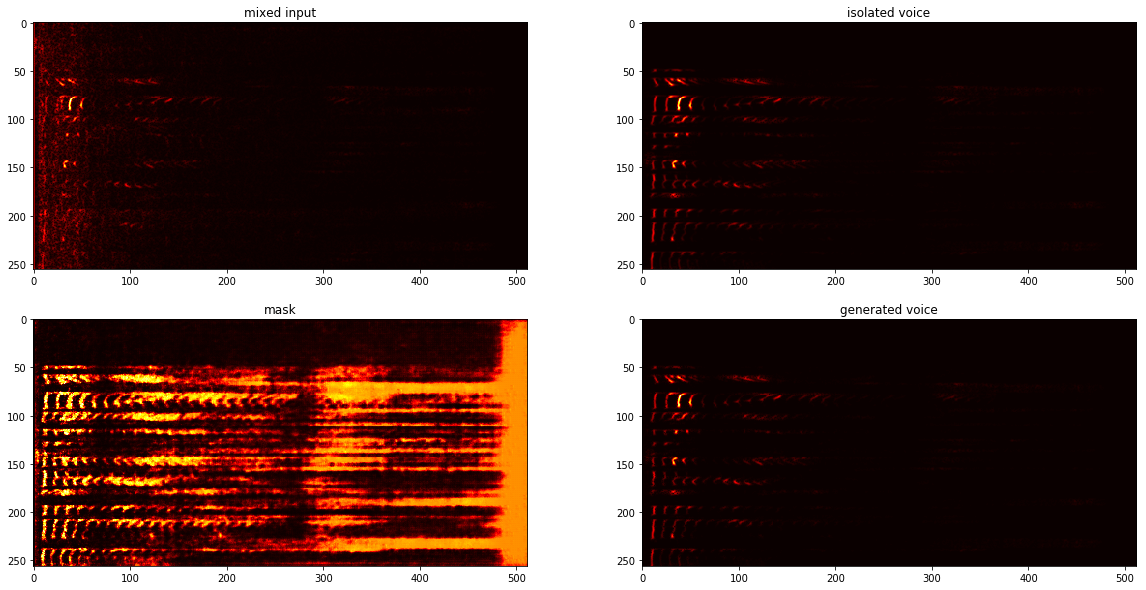

In [83]:
i=0

fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mix_inp[i,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice_inp[i,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[i,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(voice_est[i,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

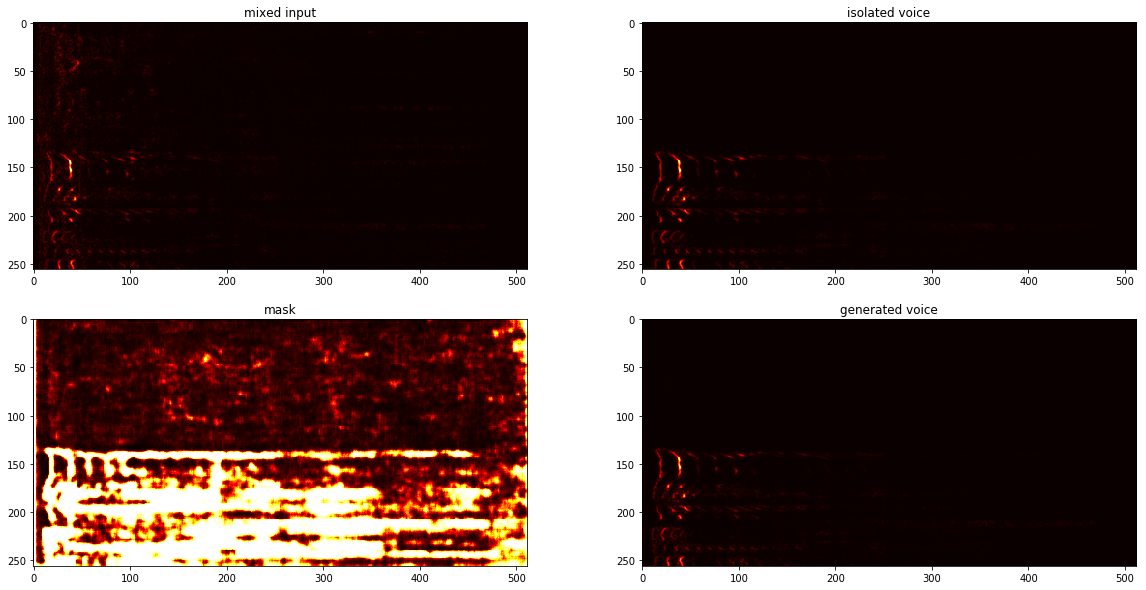

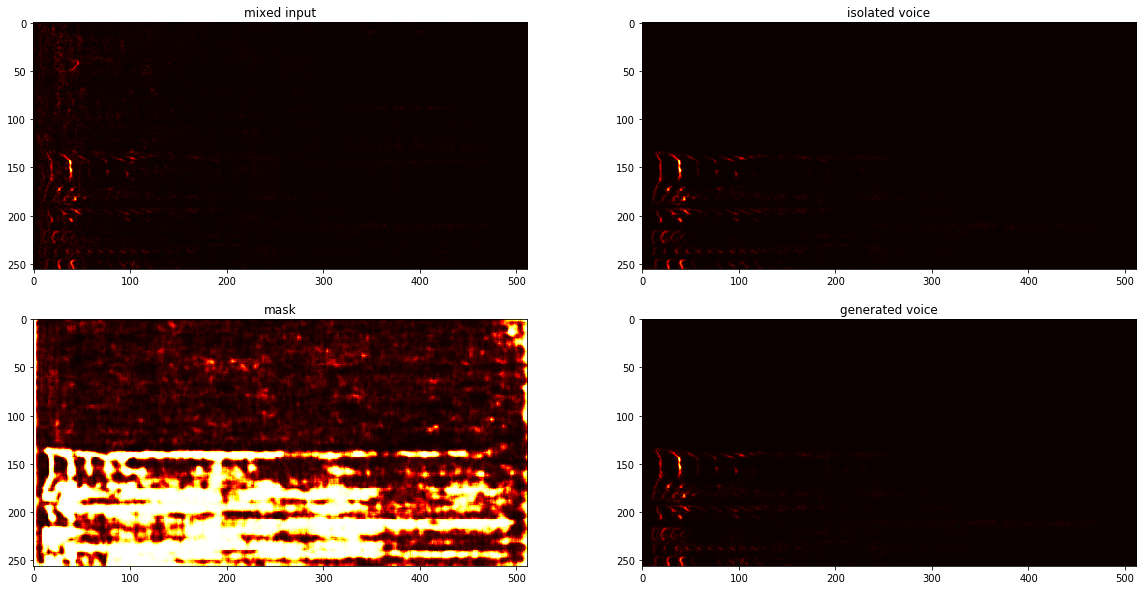

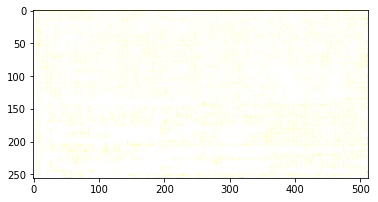

In [65]:
plt.imshow(mask[i,:,:,1])

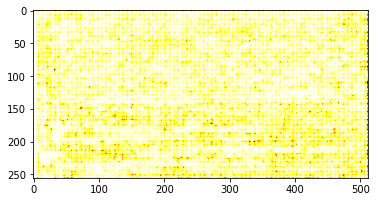

In [69]:
i=0
x = range(len(voice_est_wave[i]))
print(len(voice_est_wave))
print(len(voice_est_wave[0]))

1
65280


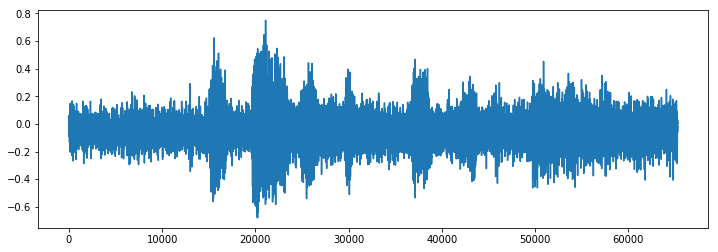

In [70]:
#  The original mixture
plt.figure(figsize=(12,4))
plt.plot(x,mix_wave[i])
ipd.Audio(mix_wave[i].T, rate=sample_rate)

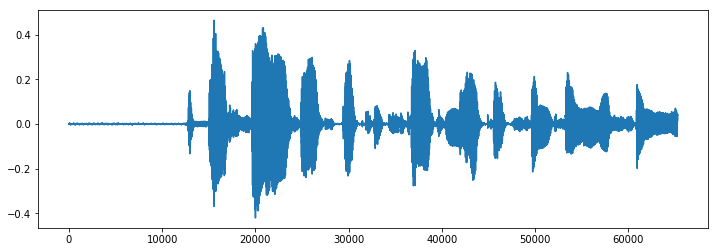

In [71]:
#  The true isolated voice 
plt.figure(figsize=(12,4))
plt.plot(x,voice_wave[i])
ipd.Audio(voice_wave[i].T, rate=sample_rate)

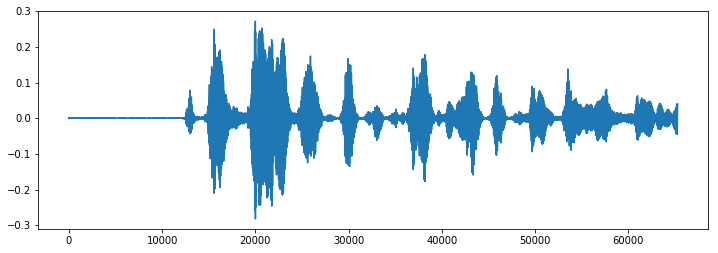

In [72]:
#  The estimated isolated voice produced by the network - real_imag
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

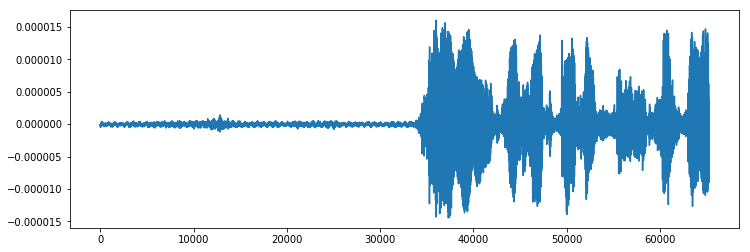

In [82]:
#  The estimated isolated voice produced by the network - mag
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

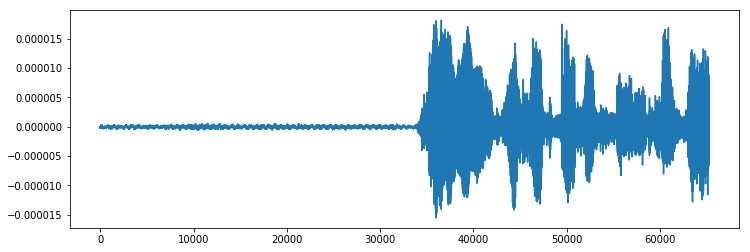

In [66]:
#  The estimated isolated voice produced by the network - mag_phse_diff
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

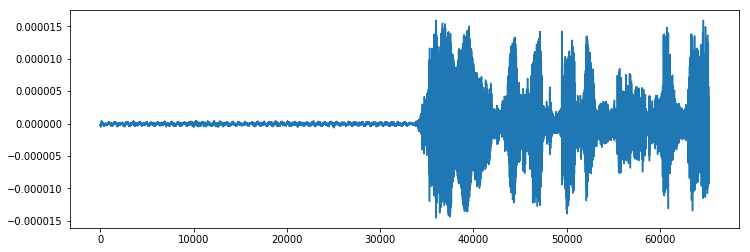

In [26]:
#  The estimated isolated voice produced by the network - mag_phase
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)